# Functions

In [ ]:
from LM_align.synthData.SynthCommon_win import *


# Generate Dataset

In [4]:
# 预生成数据
output_dir = 'pre_generated_data'  # 生成数据的目录
num_samples = 500  # 根据需要调整样本数量
skipped = pre_generate_dataset(num_samples, output_dir,
                               canvas_size=(256, 256),
                               min_size=20, max_size=40,
                               max_attempts=1000, max_retry=5)

Saved sample 0: {'obj': 'apple', 'a': 9, 'b': 2, 'c': 11}
Saved sample 1: {'obj': 'cat', 'a': 1, 'b': 14, 'c': 15}
Saved sample 2: {'obj': 'boat', 'a': 15, 'b': 1, 'c': 16}
Saved sample 3: {'obj': 'house', 'a': 7, 'b': 6, 'c': 13}
Saved sample 4: {'obj': 'bicycle', 'a': 15, 'b': 2, 'c': 17}
Saved sample 5: {'obj': 'car', 'a': 1, 'b': 2, 'c': 3}
Saved sample 6: {'obj': 'bicycle', 'a': 1, 'b': 12, 'c': 13}
Saved sample 7: {'obj': 'dog', 'a': 4, 'b': 16, 'c': 20}
Saved sample 8: {'obj': 'dog', 'a': 0, 'b': 3, 'c': 3}
Saved sample 9: {'obj': 'car', 'a': 3, 'b': 0, 'c': 3}
Saved sample 10: {'obj': 'tree', 'a': 4, 'b': 1, 'c': 5}
Saved sample 11: {'obj': 'flower', 'a': 2, 'b': 2, 'c': 4}
Saved sample 12: {'obj': 'flower', 'a': 7, 'b': 11, 'c': 18}
Saved sample 13: {'obj': 'cat', 'a': 2, 'b': 9, 'c': 11}
Saved sample 14: {'obj': 'star', 'a': 16, 'b': 4, 'c': 20}
Saved sample 15: {'obj': 'cat', 'a': 9, 'b': 0, 'c': 9}
Saved sample 16: {'obj': 'cat', 'a': 0, 'b': 6, 'c': 6}
Saved sample 17: {'o

# Load data and test

In [59]:
# 构建 Dataset 与 DataLoader
transform = transforms.ToTensor()
dataset = PreGeneratedDataset(output_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

# 测试读取一个 batch，并显示 sample 的 image_c
batch = next(iter(dataloader))
print(batch.keys())
sample_img = batch["image_c"][0].permute(1, 2, 0).numpy()
plt.imshow(sample_img)
label = batch["label"]["obj"][0]
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [39]:
def draw_emoji(emoji_name, font_size=72):
    # 尝试完整路径
    font_path = "C:/Windows/Fonts/seguiemj.ttf"  # 或 seguiemoji.ttf
    emoji_char = EMOJI_MAP[emoji_name]

    image = Image.new("RGB", (200, 200), (255, 255, 255))
    draw = ImageDraw.Draw(image)

    try:
        emoji_font = ImageFont.truetype(font_path, font_size)
    except Exception as e:
        print("Load emoji font failed:", e)
        emoji_font = ImageFont.load_default()

    # 在(50, 50)绘制
    
    # draw.text((50, 50), emoji_char, font=emoji_font, fill="black")
    draw_object(draw, emoji_name, (50, 50, 100, 100))
    display(image) 


draw_emoji("apple")

In [41]:
boxes = generate_non_overlapping_boxes(20, (200, 200), 20, 50)
img = draw_objects_on_image("apple", boxes, (200, 200))
display(img)

# Addition data distribution visualization

In [ ]:
import numpy as np
# 生成示例数据
np.random.seed(42)  # 固定随机种子
X = np.random.randint(1, 5, 1000)
Y = np.random.randint(1, 5, 1000)
plot_hist(X, Y)

# Shared-box data synth

In [5]:
import numpy as np
import random
from tqdm import tqdm

def gen_one_data_from_boxes_seq(boxes, a, b, obj_label, canvas_size):
    c = a + b
    n_idx = np.array(list(range(len(boxes))))
    a_idx = random.sample(list(n_idx), a)
    b_idx = random.sample(list(n_idx), b)
    c_idx = random.sample(list(n_idx), c)
    boxes_a = [boxes[i] for i in a_idx]
    boxes_b = [boxes[i] for i in b_idx]
    boxes_c = [boxes[i] for i in c_idx]

    image_a = draw_objects_on_image(obj_label, boxes_a, canvas_size)
    image_b = draw_objects_on_image(obj_label, boxes_b, canvas_size)
    image_c = draw_objects_on_image(obj_label, boxes_c, canvas_size)
    label = {"obj": obj_label, "a": a, "b": b, "c": c}
    return image_a, image_b, image_c, label


# ----------------------------
# 数据预生成函数：保存数据到本地
# ----------------------------
def pre_generate_oneSeqBox_dataset(num_samples, box_seq, output_dir, canvas_size=(224, 224), is_plot_hist=True):
    """
    预生成 num_samples 个数据点并保存到 output_dir 目录下。
    每个数据点保存在单独的文件夹中，包含 image_a.png, image_b.png, image_c.png 以及 label.json。
    如果某个数据点生成失败（如无法生成足够的 boxes），则跳过，并记录下来。
    """
    num_box = len(box_seq)
    os.makedirs(output_dir, exist_ok=True)
    generated = 0
    sample_index = 0
    seq_a = []
    seq_b = []
    for i in tqdm(range(num_samples)):
        obj_label = random.choice(OBJ_LIST)
        a = random.randint(1, 5)
        b = random.randint(1, 5)
        seq_a.append(a)
        seq_b.append(b)
        assert a + b <= num_box, f"Error: a + b = {a} + {b} = {a+b} > num_box = {num_box}"
        datapoint = gen_one_data_from_boxes_seq(box_seq, a, b, obj_label, canvas_size)
        image_a, image_b, image_c, label = datapoint
        # 保存到 sample_{index:04d} 文件夹下
        sample_dir = os.path.join(output_dir, f"sample_{sample_index:04d}")
        os.makedirs(sample_dir, exist_ok=True)
        image_a.save(os.path.join(sample_dir, "image_a.png"))
        image_b.save(os.path.join(sample_dir, "image_b.png"))
        image_c.save(os.path.join(sample_dir, "image_c.png"))
        # 保存 label 为 JSON 格式
        with open(os.path.join(sample_dir, "label.json"), "w", encoding="utf-8") as f:
            json.dump(label, f, ensure_ascii=False, indent=2)
        # print(f"Saved sample {sample_index}: {label}")
        generated += 1
        sample_index += 1

    print(f"Pre-generation complete. Generated {generated} samples.")
    if is_plot_hist:
        plot_hist(seq_a, seq_b)




100%|██████████| 128/128 [00:01<00:00, 70.54it/s]


Pre-generation complete. Generated 128 samples.


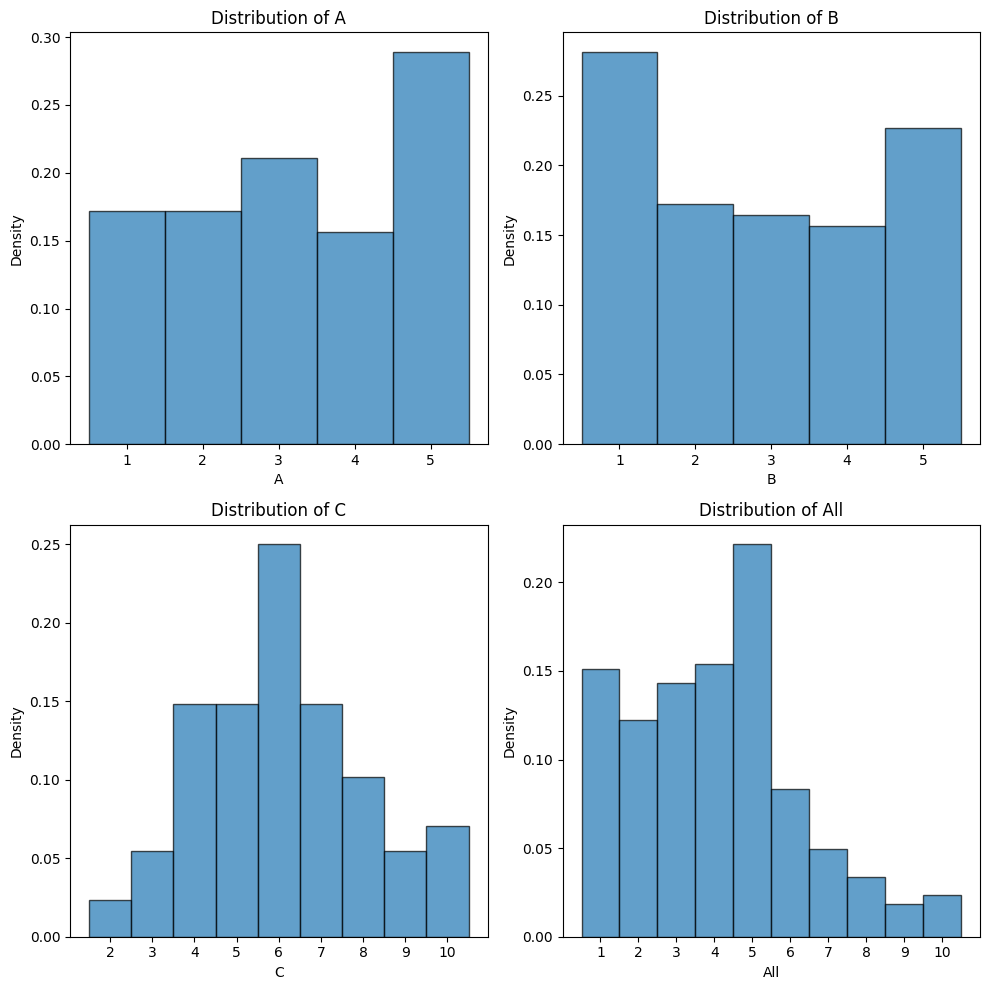

100%|██████████| 64/64 [00:00<00:00, 77.77it/s]

Pre-generation complete. Generated 64 samples.


In [14]:
num_samples_train = 128 # 根据需要调整样本数量
num_samples_val = 64
output_dir_train = "new_icon_train_win"
output_dir_val = "new_icon_val_win"
num_box = 12
canvas_size = (224, 224)
min_size = 30
max_size = 50

box_seq = generate_non_overlapping_boxes(num_box, canvas_size, min_size, max_size, max_attempts=1000, max_retry=5)
pre_generate_oneSeqBox_dataset(num_samples_train, box_seq, output_dir_train, canvas_size=canvas_size)
pre_generate_oneSeqBox_dataset(num_samples_val, box_seq, output_dir_val, canvas_size=canvas_size, is_plot_hist=False)

# Recurrent Blindfold Synth

In [ ]:
data = gen_recurrent_data(128)
print(data[0])
seq_a = [d[3]["a"] for d in data]
seq_b = [d[3]["b"] for d in data]
plot_hist(seq_a, seq_b)

In [5]:
a = [1, 2, 3, 4, 5]
b = [2,3,1,0,0,0,0,0,0]

import numpy as np
a = np.array(a)
b = np.array(b)

a[b]


# 生成递归蒙眼数据 sample

100%|██████████| 16/16 [00:00<00:00, 23.10it/s]


Pre-generation complete. Generated 60 samples.


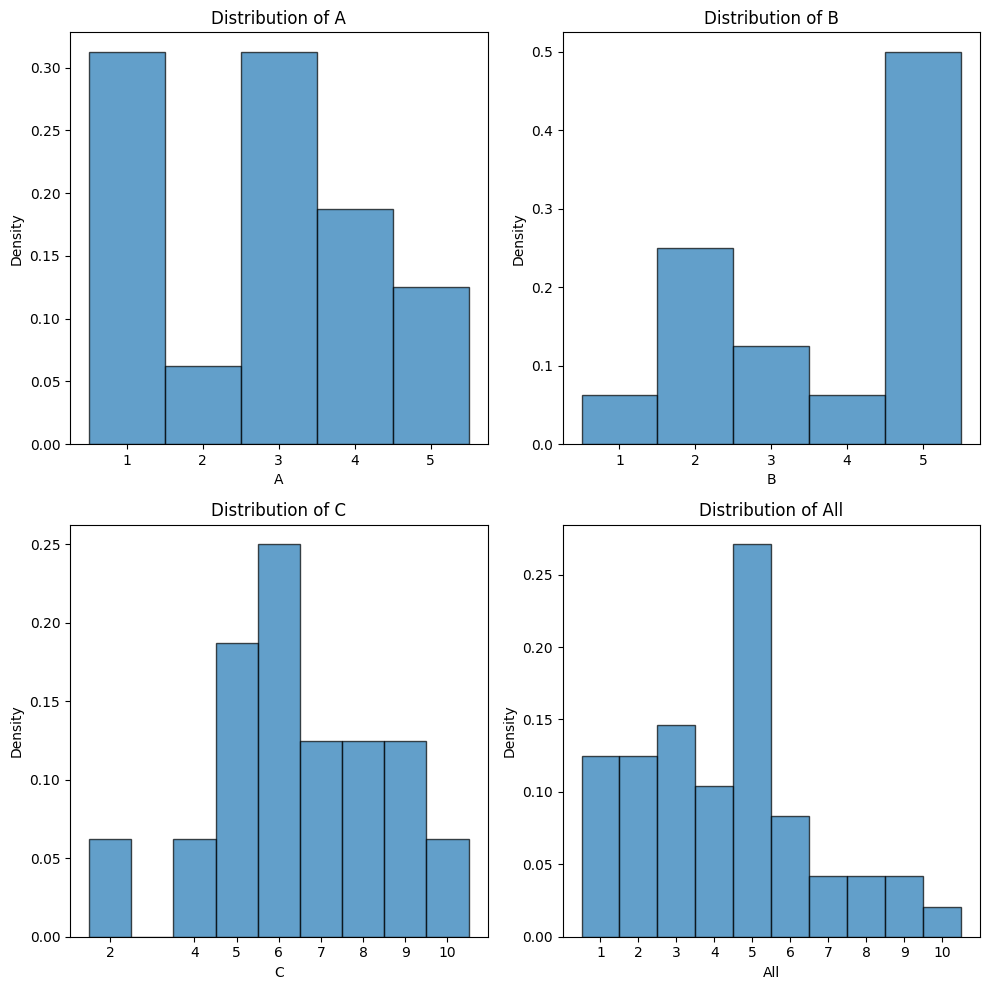

100%|██████████| 16/16 [00:00<00:00, 16.19it/s]

Pre-generation complete. Generated 69 samples.


In [ ]:

from LM_align.synthData.SynthCommon_win import *


import numpy as np
import random
from tqdm import tqdm

def gen_one_data_from_boxes_seq(boxes, a, b, obj_label, canvas_size):
    c = a + b
    n_idx = np.array(list(range(len(boxes))))
    a_idx = random.sample(list(n_idx), a)
    b_idx = random.sample(list(n_idx), b)
    c_idx = random.sample(list(n_idx), c)
    boxes_a = [boxes[i] for i in a_idx]
    boxes_b = [boxes[i] for i in b_idx]
    boxes_c = [boxes[i] for i in c_idx]

    image_a = draw_objects_on_image(obj_label, boxes_a, canvas_size)
    image_b = draw_objects_on_image(obj_label, boxes_b, canvas_size)
    image_c = draw_objects_on_image(obj_label, boxes_c, canvas_size)
    label = {"obj": obj_label, "a": a, "b": b, "c": c}
    return image_a, image_b, image_c, label


# ----------------------------
# 数据预生成函数：保存数据到本地
# ----------------------------
def pre_generate_oneSeqBox_dataset(num_samples, box_seq, output_dir, canvas_size=(224, 224), is_plot_hist=True):
    """
    预生成 num_samples 个数据点并保存到 output_dir 目录下。
    每个数据点保存在单独的文件夹中，包含 image_a.png, image_b.png, image_c.png 以及 label.json。
    如果某个数据点生成失败（如无法生成足够的 boxes），则跳过，并记录下来。
    """
    num_box = len(box_seq)
    os.makedirs(output_dir, exist_ok=True)
    generated = 0
    sample_index = 0
    seq_a = []
    seq_b = []
    for i in tqdm(range(num_samples)):
        obj_label = random.choice(OBJ_LIST)
        a = random.randint(1, 5)
        b = random.randint(1, 5)
        seq_a.append(a)
        seq_b.append(b)
        assert a + b <= num_box, f"Error: a + b = {a} + {b} = {a+b} > num_box = {num_box}"
        datapoints = recurrent_generate_data(box_seq, a+b, obj_label, canvas_size)
        for datapoint in datapoints:
            image_a, image_b, image_c, label = datapoint
            # 保存到 sample_{index:04d} 文件夹下
            sample_dir = os.path.join(output_dir, f"sample_{sample_index:04d}")
            os.makedirs(sample_dir, exist_ok=True)
            image_a.save(os.path.join(sample_dir, "image_a.png"))
            image_b.save(os.path.join(sample_dir, "image_b.png"))
            image_c.save(os.path.join(sample_dir, "image_c.png"))
            # 保存 label 为 JSON 格式
            with open(os.path.join(sample_dir, "label.json"), "w", encoding="utf-8") as f:
                json.dump(label, f, ensure_ascii=False, indent=2)
            # print(f"Saved sample {sample_index}: {label}")
            generated += 1
            sample_index += 1

    print(f"Pre-generation complete. Generated {generated} samples.")
    if is_plot_hist:
        plot_hist(seq_a, seq_b)


num_samples_train = 16 # 根据需要调整样本数量
num_samples_val = 16
output_dir_train = "new_icon_train_win"
output_dir_val = "new_icon_val_win"
num_box = 12
canvas_size = (224, 224)
# min_size = 20
# max_size = 40
min_size = 30
max_size = 50

box_seq = generate_non_overlapping_boxes(num_box, canvas_size, min_size, max_size, max_attempts=1000, max_retry=5)
pre_generate_oneSeqBox_dataset(num_samples_train, box_seq, output_dir_train, canvas_size=canvas_size)
pre_generate_oneSeqBox_dataset(num_samples_val, box_seq, output_dir_val, canvas_size=canvas_size, is_plot_hist=False)